This notebook is designed to give a demo of how our scheme works on real world data. I downloaded a small houseing price dataset from [kaggle Housing Prices Dataset](https://www.kaggle.com/apratim87/housingdata). 
I'll perform a low_rank approximation on this dataset to see how it performs.


In [257]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

def softMax(A):
    '''
    This function takes a numpy array and compute a softmax function 
    on each column.
    It finally returns a probability of each cell being error
    '''
    exp_A = np.exp(A)
    sum_exp = np.sum(exp_A, axis = 0)
    
    prob = exp_A / sum_exp
    return prob
    


def low_rank_approx_PCA(A, k):
    '''
    This function computes a PCA on a given matrix A then
    approximates it with rank k and finally 
    returns an approximated matrix A_approx reconstructed by those approximations
    '''
    # Feed the data into PCA
    pca = PCA(n_components=k)
    pca.fit(A)    
    
    # Reconstruct data
    coef_matrix = np.dot(A - pca.mean_, pca.components_.T)
    approximation = np.dot(coef_matrix, pca.components_)
    
    return abs(A - approximation)
    
    
def low_rank_approx_kernelPCA(A, k, kern):
    '''
    This function computes a kernel PCA on a given matrix A then 
    approximates it with rank k and finally
    returns an approximated matrix A_approx reconstructed by those approximations
    '''
    # Feed the data into KPCA
    kpca = KernelPCA(n_components=k, kernel=kern, fit_inverse_transform=True)
    A_kpca = kpca.fit_transform(A)
    A_back = kpca.inverse_transform(A_kpca)
    
    return abs(A - A_back)
    

In [258]:
# Load data and check for any onbious errors
data_path = './datasets/housingdata.csv'
columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
housing_data = pd.read_csv(data_path, names=columns)
# Put data in numpy array
housing_array = housing_data.values
# Check summary of data to see if there's any obvious error
print(housing_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
CRIM       506 non-null float64
ZN         506 non-null float64
INDUS      506 non-null float64
CHAS       506 non-null int64
NOX        506 non-null float64
RM         506 non-null float64
AGE        506 non-null float64
DIS        506 non-null float64
RAD        506 non-null int64
TAX        506 non-null int64
PTRATIO    506 non-null float64
B          506 non-null float64
LSTAT      506 non-null float64
MEDV       506 non-null float64
dtypes: float64(11), int64(3)
memory usage: 55.4 KB
None


I'll first run a simple low rank approximation with PCA on the dataset. Then I'll randomly invalidate some cells and shift cells in one row by 1 and rerun the experiment. Finally, I'll check it with kernel PCA to see if it can detect any potential errors. 

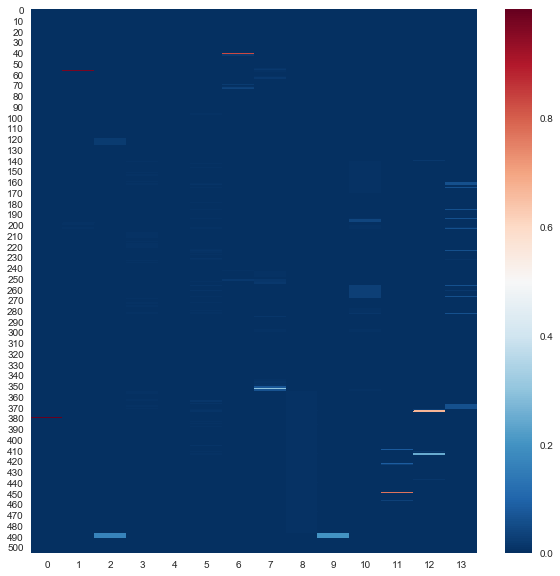

In [259]:
# Now calculate the diference between data and approximation with different k
# Since there are 14 columns, valid k can be chosen from 1 to 13. 
# Just use k = 13 as a demo. If it doesn't work well, I'll try another k
difference = abs(housing_array - low_rank_approx_PCA(housing_array, 13))
prob_distribution = softMax(difference)
plt.figure(figsize=(10, 10))
ax = sns.heatmap(prob_distribution, cmap = "RdBu_r")

From the heatmap above, we can get a sense of how our algorithm thinks of our data as a linear relationship. Now, I'm making some error in the data. I'll choose the region where it is black indicating low probabilities of being erroneous. 
I'll set the cell at (110, 4) to an odd value and shift row 117 to left by one. 

In [260]:
# check cell at (110, 4)
print(housing_array[110, 4])

0.52


In [261]:
# Create an error matrix for later use
housing_error = np.array(housing_array)
# Set errors
housing_error[110, 4] = 100
# Shift row 117 to left by 1 and pad last entry by a -1, which is the normal way of treating NaN
rows, columns = housing_error.shape
print(housing_error[117, :])

[1.5098e-01 0.0000e+00 1.0010e+01 0.0000e+00 5.4700e-01 6.0210e+00
 8.2600e+01 2.7474e+00 6.0000e+00 4.3200e+02 1.7800e+01 3.9451e+02
 1.0300e+01 1.9200e+01]


In [262]:
for i in range(0, columns - 1):
    housing_error[117, i] = housing_error[117, i+1]
housing_error[117, columns - 1] = -1
print(housing_error[117, :])

[  0.      10.01     0.       0.547    6.021   82.6      2.7474   6.
 432.      17.8    394.51    10.3     19.2     -1.    ]


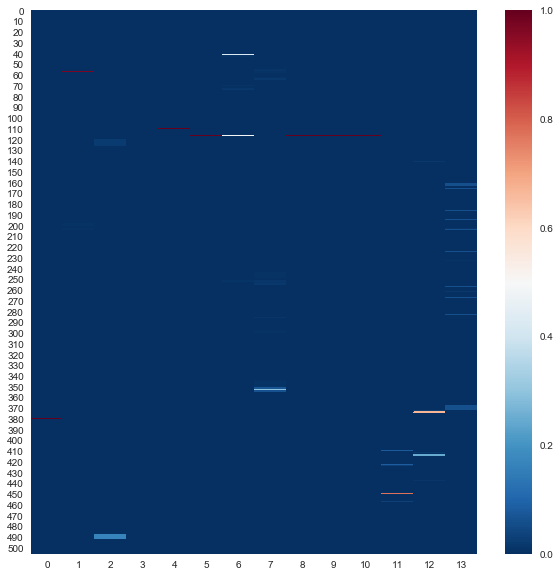

In [263]:
# Now, redo the whole procedure on housing_error
difference = abs(housing_error - low_rank_approx_PCA(housing_error, 13))
prob_distribution = softMax(difference)
plt.figure(figsize=(10, 10))
ax = sns.heatmap(prob_distribution, cmap = "RdBu_r")

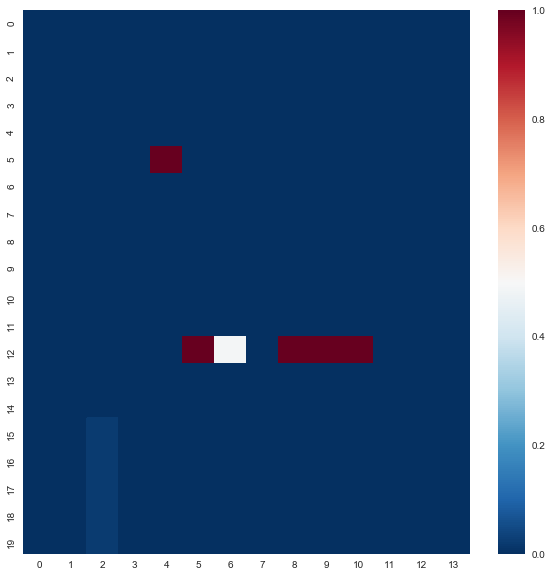

In [264]:
# Take a closer look at the place that we put errors
plt.figure(figsize=(10, 10))
ax = sns.heatmap(prob_distribution[105:125, :], cmap = "RdBu_r")

From the above figure, since I cut the matrix from row 105 to row 125, row 5 stands for 110 and row 12 stands for 107. We can clearly see the probability of cell (110, 4) being erroneous boosted and we can also see a region on row 117 with a boosted probability. This should gives us a sense that our scheme is working on these types of errors. 

For everything above, we just use a linear view of our data to detect errors. Let's now check what would happen if we use a nonlinear view to detect errors in our data, i.e, use kernel PCA to do approximations. I will use the same datasets and with different error with the same selection of k, i.e, k=13. Also, for the sake of demo, I'll just use Gaussian Kernel in this case. 

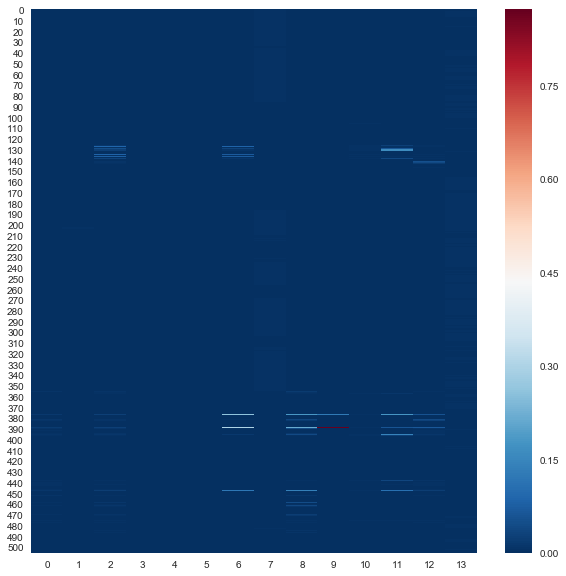

In [265]:
# Now, redo the whole procedure on original data
difference = abs(housing_array - low_rank_approx_kernelPCA(housing_array, 13, 'rbf'))
prob_distribution = softMax(difference)
plt.figure(figsize=(10, 10))
ax = sns.heatmap(prob_distribution, cmap = "RdBu_r")

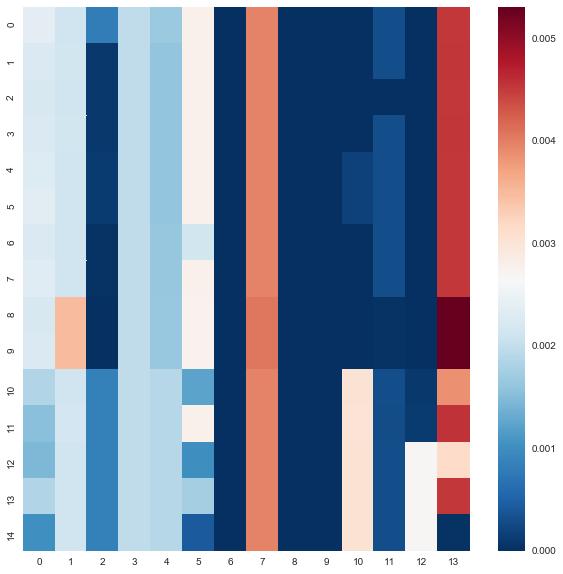

In [266]:
# Take a closer look at range of row(195, 210)
plt.figure(figsize=(10, 10))
ax = sns.heatmap(prob_distribution[195:210, :], cmap = "RdBu_r")

I would select a cell that has low probability of being erroneous for now, say (196, 2) and row 203 to shift to left by 1

In [267]:
# check cell at (196, 2)
print(housing_array[196, 2])

1.52


In [268]:
# Create an error matrix 
housing_error = np.array(housing_array)
# Set errors
housing_error[196, 2] = 100
# Shift row 117 to left by 1 and pad last entry by a -1, which is the normal way of treating NaN
rows, columns = housing_error.shape
print(housing_error[203, :])

[3.5100e-02 9.5000e+01 2.6800e+00 0.0000e+00 4.1610e-01 7.8530e+00
 3.3200e+01 5.1180e+00 4.0000e+00 2.2400e+02 1.4700e+01 3.9278e+02
 3.8100e+00 4.8500e+01]


In [269]:
for i in range(0, columns - 1):
    housing_error[203, i] = housing_error[203, i+1]
housing_error[203, columns - 1] = -1
print(housing_error[203, :])

[ 95.       2.68     0.       0.4161   7.853   33.2      5.118    4.
 224.      14.7    392.78     3.81    48.5     -1.    ]


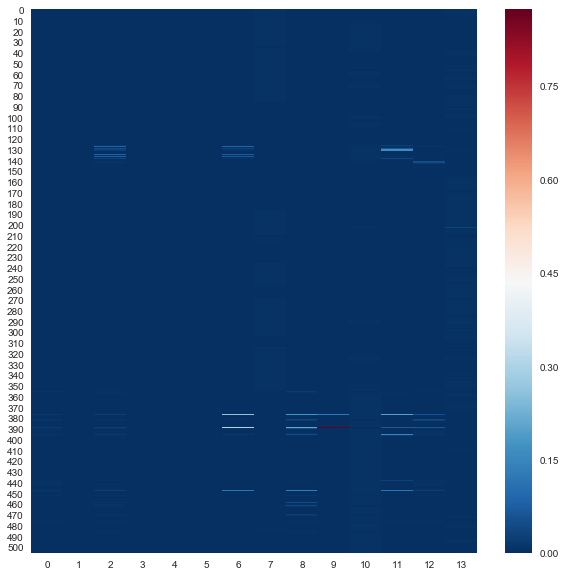

In [270]:
# Now, redo the whole procedure on dirty data
difference = abs(housing_error - low_rank_approx_kernelPCA(housing_error, 13, 'rbf'))
prob_distribution_error = softMax(difference)
plt.figure(figsize=(10, 10))
ax = sns.heatmap(prob_distribution_error, cmap = "RdBu_r")

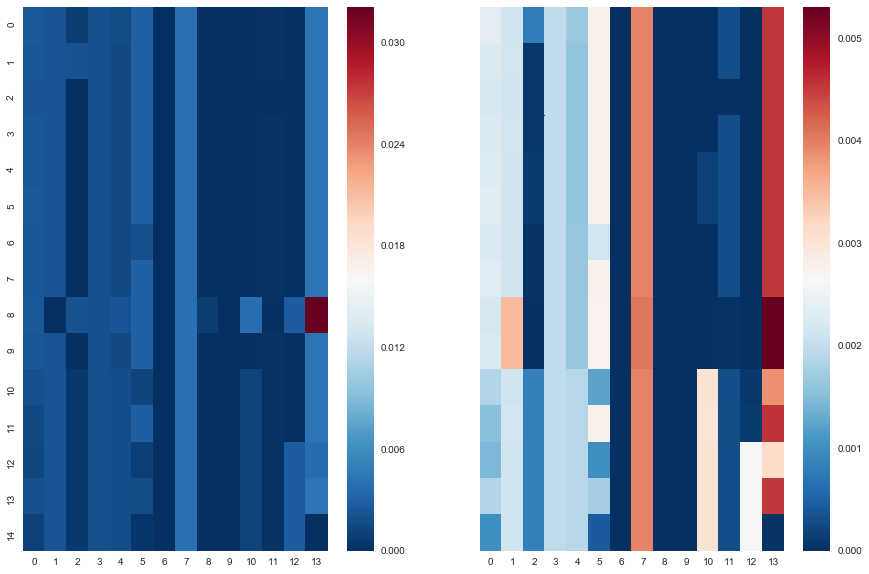

In [271]:
# Take a closer look at the place that we put errors
fig,axn = plt.subplots(1, 2, sharex=True, sharey=True)
fig.set_figheight(10)
fig.set_figwidth(15)
next = prob_distribution_error[195:210, :]
for ax in axn.flat:
    sns.heatmap(next, cmap = "RdBu_r", ax=ax)
    next = prob_distribution[195:210, :]


Actually, left figure shows the heatmap of dirty data and left figure shows the heatmap of original data. This output is odd, we might conclude that for this data nonlinear relationship may not work well on detecting types of errors that we generate in this demo. Or actually the problem is about kernel choice. 
Try a linear kernel now.  

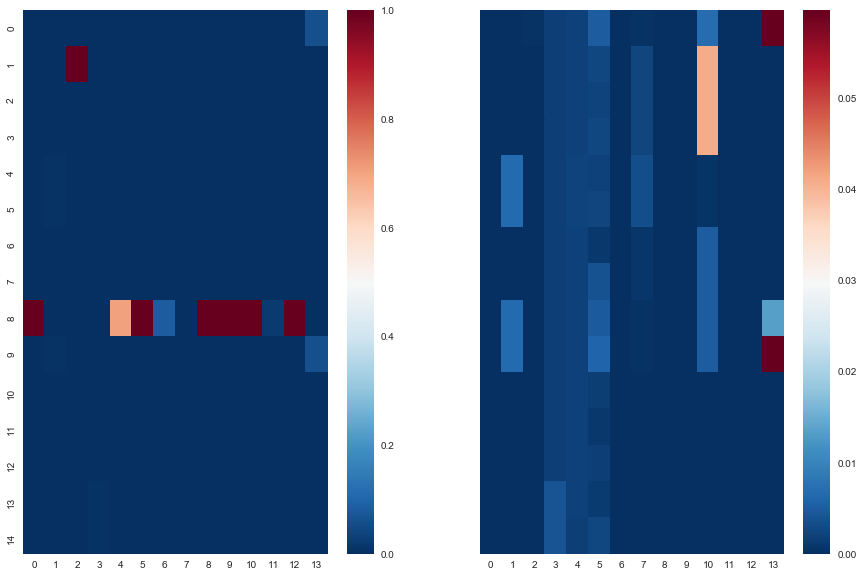

In [273]:
# For Original data, linear kernel
difference_origin_linear = abs(housing_array - low_rank_approx_kernelPCA(housing_array, 13, 'linear'))
prob_distribution_origin_linear = softMax(difference_origin_linear)

# For dirty data, linear kernel
difference_dirty_linear = abs(housing_error - low_rank_approx_kernelPCA(housing_error, 13, 'linear'))
prob_distribution_dirty_linear = softMax(difference_dirty_linear)

# Now plot
fig,axn = plt.subplots(1, 2, sharex=True, sharey=True)
fig.set_figheight(10)
fig.set_figwidth(15)
next = prob_distribution_dirty_linear[195:210, :]
for ax in axn.flat:
    sns.heatmap(next, cmap = "RdBu_r", ax=ax)
    next = prob_distribution_origin_linear[195:210, :]

Now we can see, by a linear kernel, we actually detected those errors manually set by us. 
Using kernel PCA with a linear kernel actually can be viewed as regular PCA, which detects linear relationships of data. This actually brings a thought: should the choice of kernel be associated types of errors? However, we do not know types of errors in advance.
It remains to explore how to cleverly choose kernels with a given dataset. Also, don't forget the choice of k. In this experiment, we have 14 features and I choose k=13 for demo. However, it is not necessary that k=d-1 is the optimal choice, where d is the dimension of data points. 